C:\Users\Helen\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Helen\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25 | Train Loss: 2.0849 | Val Loss: 0.7415
Epoch 2/25 | Train Loss: 0.5096 | Val Loss: 0.4468
Epoch 3/25 | Train Loss: 0.1145 | Val Loss: 0.2989
Epoch 4/25 | Train Loss: 0.0448 | Val Loss: 0.2514
Epoch 5/25 | Train Loss: 0.0430 | Val Loss: 0.2397
Epoch 6/25 | Train Loss: 0.0237 | Val Loss: 0.2284
Epoch 7/25 | Train Loss: 0.0187 | Val Loss: 0.2488
Epoch 8/25 | Train Loss: 0.0196 | Val Loss: 0.2090
Epoch 9/25 | Train Loss: 0.0159 | Val Loss: 0.2258
Epoch 10/25 | Train Loss: 0.0121 | Val Loss: 0.2073
Epoch 11/25 | Train Loss: 0.0081 | Val Loss: 0.1792
Epoch 12/25 | Train Loss: 0.0116 | Val Loss: 0.2126
Epoch 13/25 | Train Loss: 0.0141 | Val Loss: 0.2176
Epoch 14/25 | Train Loss: 0.0112 | Val Loss: 0.2037
Epoch 15/25 | Train Loss: 0.0062 | Val Loss: 0.1994
Epoch 16/25 | Train Loss: 0.0087 | Val Loss: 0.1719
Epoch 17/25 | Train Loss: 0.0223 | Val Loss: 0.3189
Epoch 18/25 | Train Loss: 0.0566 | Val Loss: 0.6827
Epoch 19/25 | Train Loss: 0.0906 | Val Loss: 0.6769
Epoch 20/25 | Train L

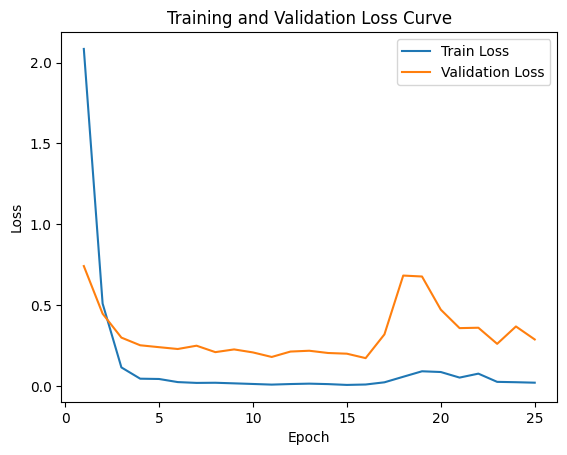

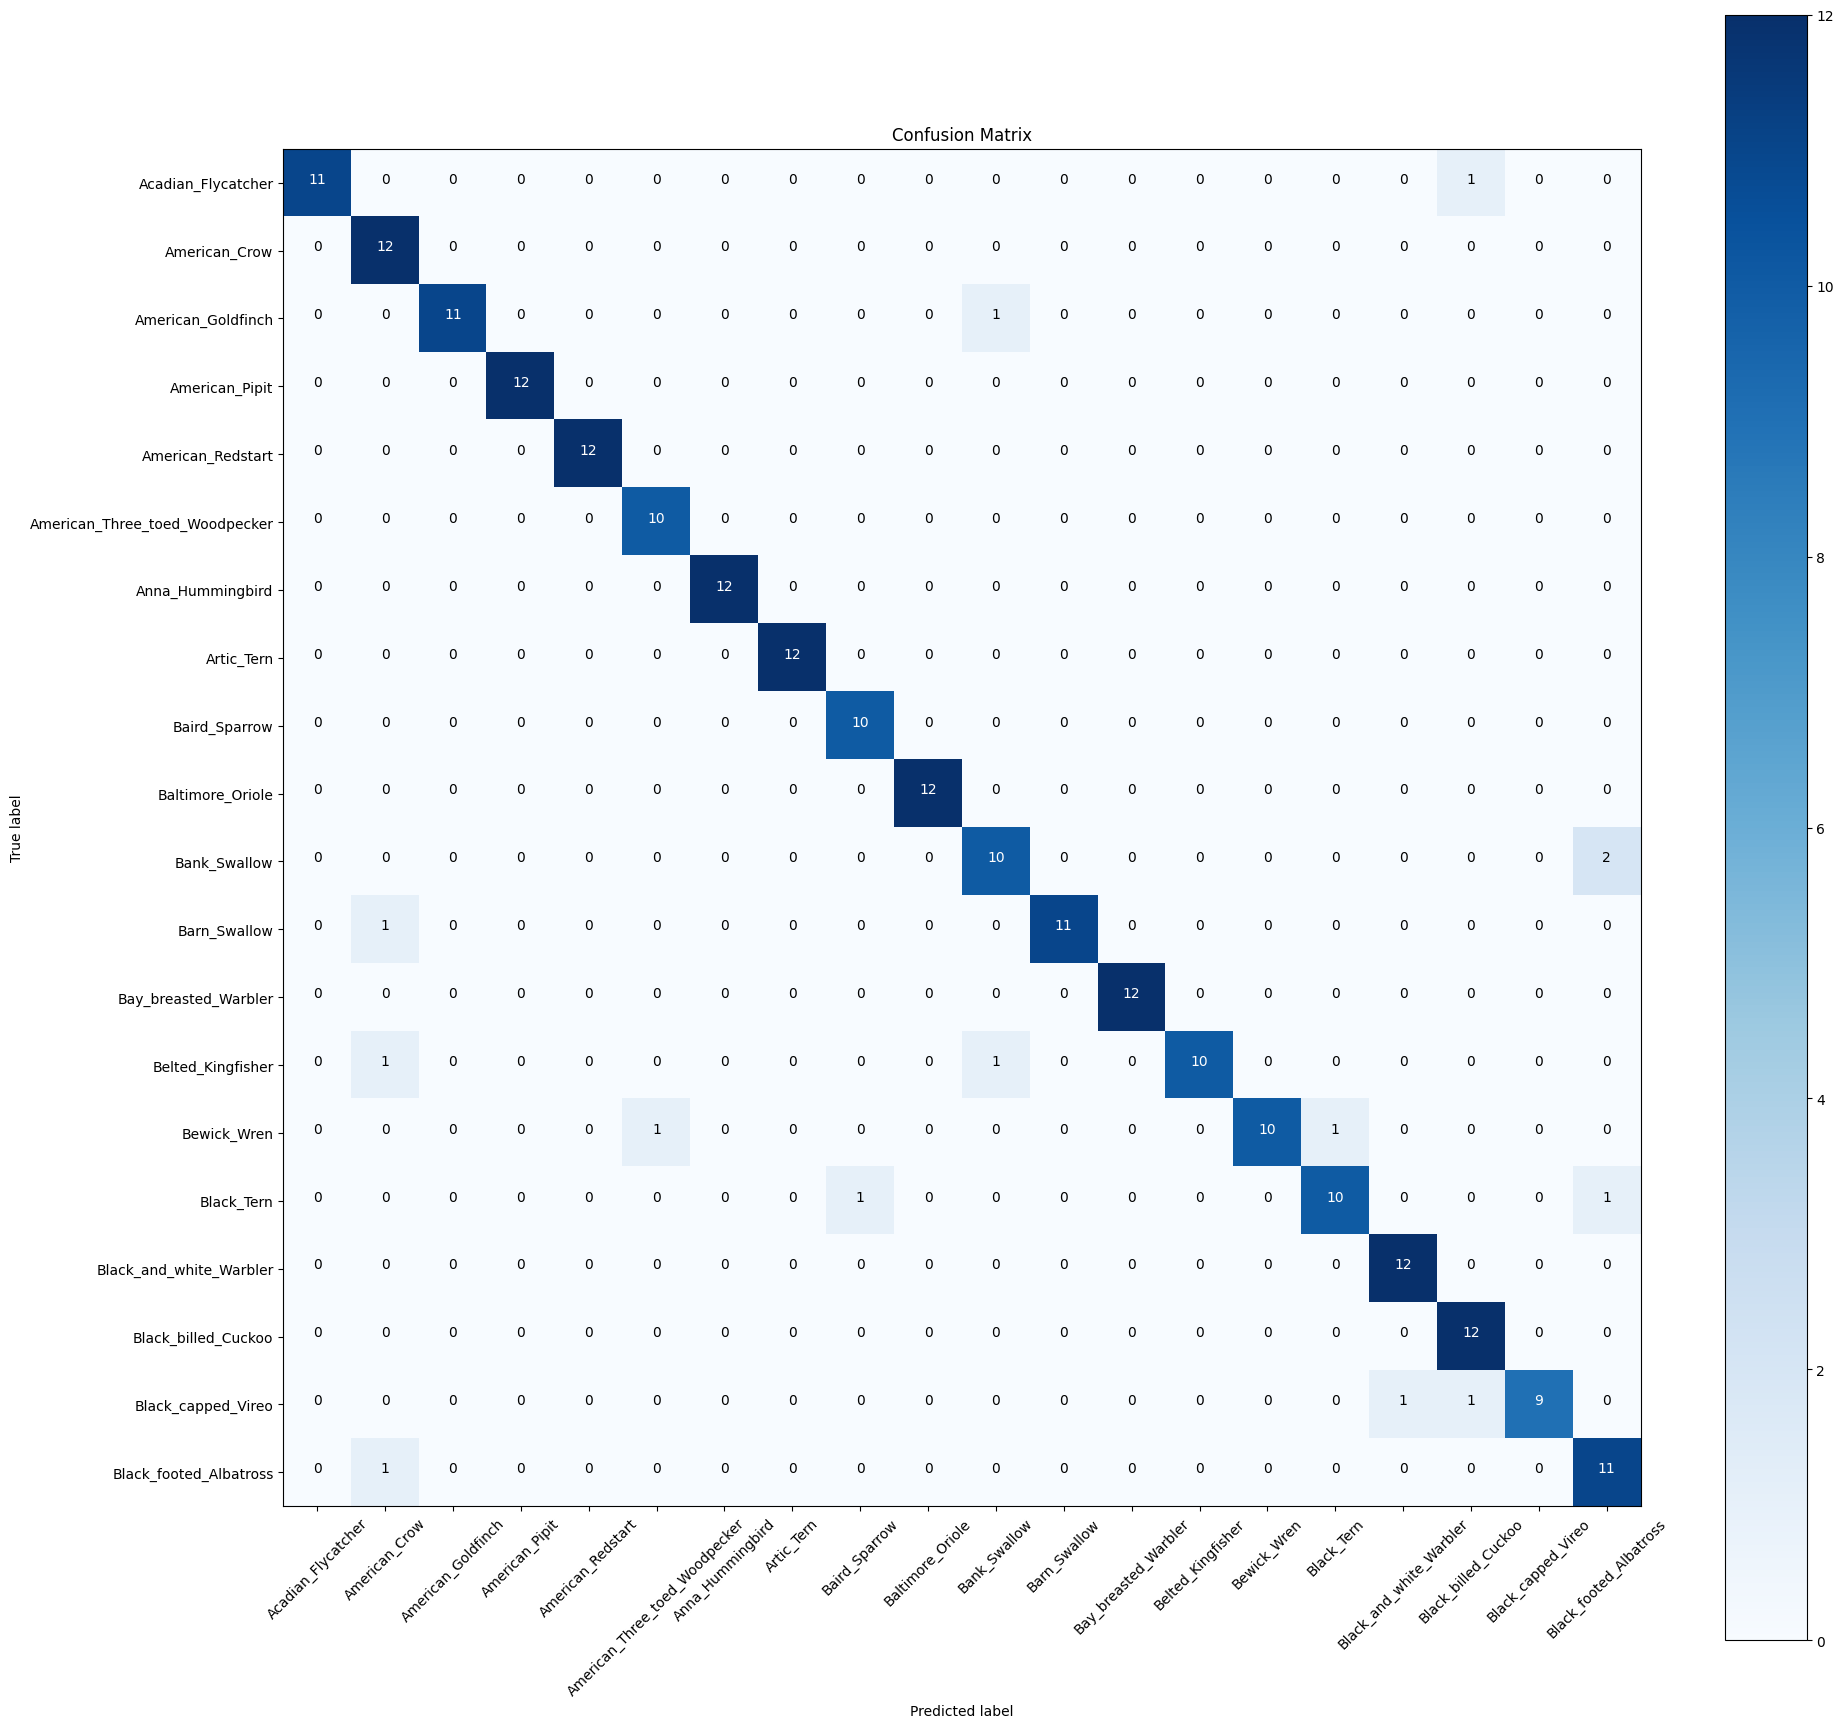

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

#the main info for model
train_dir = "C:\\Users\\Helen\\OneDrive\\Desktop\\Bapp\\Ctrain"  #can be replaced
test_dir = "C:\\Users\\Helen\\OneDrive\\Desktop\\Bapp\\Vtest"    #can be replaced

batch_size = 32
num_epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#transforming the data
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_transforms = val_transforms  #same transform as val_transforms

# splitting the data accordingly with already set class folders for training and testing
full_train_dataset = datasets.ImageFolder(train_dir, transform=None)
num_classes = len(full_train_dataset.classes) #r: this is for the class name being the folder and only the designated folder

all_labels = [label for _, label in full_train_dataset.samples] #extracts the label indices from the dataset
train_idx, val_idx = train_test_split(   
    list(range(len(full_train_dataset))),  #gives the indices
    test_size=0.2,
    stratify=targets,
    random_state=42
)

train_dataset_sub = Subset(full_train_dataset, train_idx)  #contains samples of only train_idx
val_dataset_sub = Subset(full_train_dataset, val_idx)      ##contains samples of only val_idx

train_dataset_sub.dataset.transform = train_transforms
val_dataset_sub.dataset.transform = val_transforms

test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

#loading the dataset
train_loader = DataLoader(train_dataset_sub, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset_sub,   batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4)

#loading and seting up the model for the data
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#model training block
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    #training begins
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_dataset_sub)
    train_losses.append(train_loss)

    # validation begins
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_dataset_sub)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

#model final testing
model.eval()
all_preds = []
all_labels = []
test_loss = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
test_loss /= len(test_dataset)

print(f"\nFinal Test Loss: {test_loss:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes, zero_division=0))

#loss plotting
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curve')
plt.show()

#showing the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(20, 18))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')

classes = test_dataset.classes
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()